# Human-in-the-loop

In this example we will build a ReAct Agent that has a human in the loop. We will use the human to approve specific actions.

This examples builds off the base chat executor. It is highly recommended you learn about that executor before going through this notebook. You can find documentation for that example [here](./base.ipynb).

Any modifications of that example are called below with **MODIFICATION**, so if you are looking for the differences you can just search for that.

## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_openai tavily-python

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

OpenAI API Key: ········
Tavily API Key: ········


Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")

LangSmith API Key: ········


## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use a built-in search tool via Tavily.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/modules/agents/tools/custom_tools) on how to do that.


In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

We can now wrap these tools in a simple ToolExecutor.
This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output.
A ToolInvocation is any class with `tool` and `tool_input` attribute.


In [2]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.


In [3]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [4]:
model = model.bind_tools(tools)

## Define the agent state

The main type of graph in `langgraph` is the [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph).
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is always added to.


In [5]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/docs/expression_language/).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.


In [6]:
from langgraph.prebuilt import ToolInvocation
from langchain_core.messages import ToolMessage


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [7]:
# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        ToolMessage(
            content=str(response),
            name=tc["name"],
            tool_call_id=tc["id"],
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # We return a list, because this will get added to the existing list
    return {"messages": tool_messages}

## Define the graph

We can now put it all together and define the graph!

**MODIFICATION**

We modify the graph to **interrupt** before calling the tools. This lets the user give approval to continue. Note that this is a simple example and we could modify it to change the tool input, use some other channel besides input, etc.

In [8]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=MemorySaver(), interrupt_before=["action"])

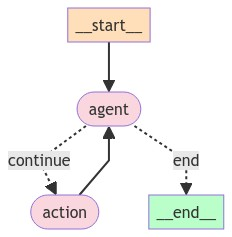

In [9]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/docs/expression_language/) as all other LangChain runnables.

In [11]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
config = {"configurable": {"thread_id": "thread-1"}}
while True:
    for output in app.stream(inputs, config):
        # stream() yields dictionaries with output keyed by node name
        for key, value in output.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    snapshot = app.get_state(config)
    # If "next" is present, it means we've interrupted mid-execution
    if not snapshot.next:
        break
    inputs = None
    response = input(
        "Do you approve the next step? Type y if you do, anything else to stop: "
    )
    if response != "y":
        break

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_lsdncO46fHYkzrGlYYuXfxUg', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-8cf32ab2-564c-4bca-8439-28095ffefef3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_lsdncO46fHYkzrGlYYuXfxUg'}], usage_metadata={'input_tokens': 87, 'output_tokens': 21, 'total_tokens': 108})]}

---



Do you approve the next step? Type y if you do, anything else to stop:  y


Output from node 'action':
---
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1716915235, \'localtime\': \'2024-05-28 9:53\'}, \'current\': {\'last_updated_epoch\': 1716914700, \'last_updated\': \'2024-05-28 09:45\', \'temp_c\': 12.8, \'temp_f\': 55.0, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/116.png\', \'code\': 1003}, \'wind_mph\': 10.5, \'wind_kph\': 16.9, \'wind_degree\': 250, \'wind_dir\': \'WSW\', \'pressure_mb\': 1019.0, \'pressure_in\': 30.09, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 83, \'cloud\': 50, \'feelslike_c\': 11.9, \'feelslike_f\': 53.3, \'windchill_c\': 11.4, \'windchill_f\': 52.5, \'heatindex_c\': 12.5, \'heatindex_f\': 54.5, \'dewpoint

## Conversational interrupt

We can also have the verification take place naturally as part of the conversation.

This would allow conversations of the form:
```
Human: Hello, what is the weather in San Francisco?

AI: I will execute an API call with {params} parameters,
should I go ahead?

Human: yes

AI: It is sunny in San Francisco.
```

Some providers require the result of a tool call (i.e., a [ToolMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.tool.ToolMessage.html)) to immediately follow a message with tool calls. To support this, here we add a `hidden` boolean to messages in the state. We hide messages with tool calls, and add them to the chat only after verification.

In [10]:
import json
from typing import Optional, Tuple

from langchain_core.messages import AIMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[Tuple[BaseMessage, bool]], operator.add]
    """Tuple of (message: BaseMessage, hidden: bool) specifying if the
    message should be hidden from the chat."""


# Define the function to verify tool calls
def verify_tool(state):
    message = [
        message
        for message, hidden in state["messages"]
        if hidden
    ][-1]
    # Assemble tool calls into a message
    serialized_tool_calls = json.dumps(
        message.tool_calls,
        indent=2,
    )
    message = AIMessage(
        content=(
            "I plan to invoke the following tools, do you approve?\n\n"
            "Type 'y' if you do, anything else to stop.\n\n"
            f"{serialized_tool_calls}"
        )
    )

    return {"messages": [(message, False)]}


# Update call_model function to "hide" tool call messages.
# This is done because some providers (e.g., OpenAI) require tool messages
# to immediately follow messages with tool calls.
def call_model(state):
    messages = [
        message
        for message, hidden in state["messages"]
        if not hidden
    ]
    response = model.invoke(messages)
    if response.tool_calls:
        hidden = True
    else:
        hidden = False
    return {"messages": [(response, hidden)]}

# Update call_tool function to execute tools, then
# prefix the ToolMessage with the hidden tool call.
def call_tool(state):
    last_message = [
        message
        for message, hidden in state["messages"]
        if hidden
    ][-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        (
            ToolMessage(
                content=str(response),
                name=tc["name"],
                tool_call_id=tc["id"],
            ),
            False,
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # Add back in the stored tool_call_message
    return {"messages": [(last_message, False)] + tool_messages}


# Define the function that routes a HumanMessage. This could be a verification
# message, or a normal conversational message.
def route_message(state):
    last_message, _ = state["messages"][-1]
    if last_message.content == "y":
        return "action"
    else:
        return "agent"


# Define the function that determines whether to call tools or not
def should_continue(state):
    message, hidden = state["messages"][-1]
    if hidden:
        return "tool_calls"
    else:
        return "end"


def entrypoint(state):
    return {"messages": []}

In [11]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)

# Add entrypoint node so we can immediately enter conditional edge
workflow.add_node("entrypoint", entrypoint)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Add a node for verifying the tool call
workflow.add_node("verify", verify_tool)

workflow.set_entry_point("entrypoint")

# Add conditional edge from entrypoint
workflow.add_conditional_edges(
    "entrypoint",
    route_message,
    {
        "action": "action",
        "agent": "agent",
    },
)

# Add a conditional edge from verification node
# to tool execution
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tool_calls": "verify",
        "end": END,
    },
)

workflow.add_edge("action", "agent")
workflow.add_edge("verify", END)

app = workflow.compile(checkpointer=MemorySaver())

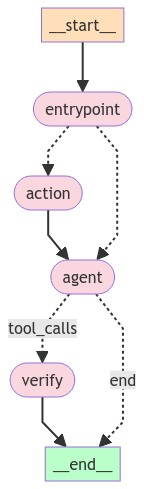

In [12]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [13]:
from langchain_core.messages import HumanMessage


config = {"configurable": {"thread_id": "thread-6"}}
while True:
    input_content = input()
    if input_content == "exit":
        break
    inputs = {
        "messages": [(HumanMessage(content=input_content), False)],
    }
    for output in app.stream(inputs, config):
        # stream() yields dictionaries with output keyed by node name
        for key, value in output.items():
            if key in ("agent", "verify"):
                print(f"\nOutput from node '{key}':")
                message = value["messages"][0][0]
                print(message.content)
                if message.tool_calls:
                    print(f"Tool calls: {message.tool_calls}")
                print()
            elif key == "action":
                print(f"\n{value}")

 hi



Output from node 'agent':
Hello! How can I assist you today?



 what is the weather in Baltimore?



Output from node 'agent':

Tool calls: [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Baltimore'}, 'id': 'call_bJ0LXYeYPBSmv9DCKvd4zxmo'}]


Output from node 'verify':
I plan to invoke the following tools, do you approve?

Type 'y' if you do, anything else to stop.

[
  {
    "name": "tavily_search_results_json",
    "args": {
      "query": "weather in Baltimore"
    },
    "id": "call_bJ0LXYeYPBSmv9DCKvd4zxmo"
  }
]



 y



{'messages': [(AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query":"weather in Baltimore"}', 'name': 'tavily_search_results_json'}, 'id': 'call_bJ0LXYeYPBSmv9DCKvd4zxmo', 'index': 0, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-0994be6e-d3b0-43df-b44b-1317ca87cd91-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Baltimore'}, 'id': 'call_bJ0LXYeYPBSmv9DCKvd4zxmo'}]), False), (ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Baltimore\', \'region\': \'Maryland\', \'country\': \'United States of America\', \'lat\': 39.29, \'lon\': -76.61, \'tz_id\': \'America/New_York\', \'localtime_epoch\': 1716928477, \'localtime\': \'2024-05-28 16:34\'}, \'current\': {\'last_updated_epoch\': 1716928200, \'last_updated\': \'2024-05-28 16:30\', \'temp_c\': 28.3, \'temp_f\': 82.9, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloud

 What is the weather in Boston?



Output from node 'agent':

Tool calls: [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Boston'}, 'id': 'call_ipEuiHWlJovUweqJSl7FBXVv'}]


Output from node 'verify':
I plan to invoke the following tools, do you approve?

Type 'y' if you do, anything else to stop.

[
  {
    "name": "tavily_search_results_json",
    "args": {
      "query": "weather in Boston"
    },
    "id": "call_ipEuiHWlJovUweqJSl7FBXVv"
  }
]



 n



Output from node 'agent':
Sure, if you have any other questions or need assistance with something else, feel free to let me know!



 exit
